In [42]:
import os
import urllib.request
import numpy as np
import torch
from models import *
from utils import *
import matplotlib.pyplot as plt

In [43]:
MODEL_URL  = "https://github.com/hasanjawad001/rheed-universal-translator/releases/download/v1.0/model_weights.pth"
MODEL_PATH = "outputs/model_weights.pth"
META_PATH  = "outputs/model_meta.npz"

os.makedirs("outputs", exist_ok=True)

if not os.path.isfile(MODEL_PATH):
    print("Model weights not found. Downloading...")
    urllib.request.urlretrieve(MODEL_URL, MODEL_PATH)
    print("Model download complete.")
else:
    print("Model weights found. Skipping download.")

# ---- load metadata ----
meta = np.load(META_PATH)
min_stoich = float(meta["min_stoich"])
max_stoich = float(meta["max_stoich"])
min_image  = float(meta["min_image"])
max_image  = float(meta["max_image"])
IMG_HW     = tuple(meta["IMG_HW"])

loaded_data = np.load('inputs/rheed_stoich_data.npz')
stoich = loaded_data['stoich'].astype(np.float32)
images = loaded_data['images'].astype(np.float32)

print(stoich.shape, images.shape)

Model weights found. Skipping download.
(31,) (31, 540, 720)


In [44]:
# ---- load model ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UniversalTranslator(IMG_HW).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

UniversalTranslator(
  (enc_img): EncImg(
    (net): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
    )
    (fc): Sequential(
      (0): Linear(in_features=391680, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=48, bias=True)
    )
  )
  (enc_sto): EncSto(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=48, bias=True)
    )
  )
  (enc_shared): EncShared(
    (net): Sequential(
      (0): Linear(in_features=48, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=12, bias=True)
    )
  )
  (dec_shared): DecShared(
    (net): Sequential(
      (0): Linear(in_fea

Input: RHEED image → Output: reconstructed RHEED image and stoichiometry

[Image → (Image + Sto)] True sto: 47.1691 | Pred sto: 47.1388


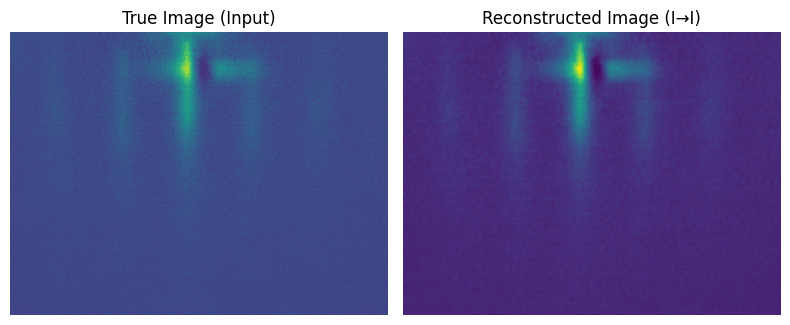

In [45]:
# ===============================
# CASE 1: Image → (Image + Sto)
# ===============================

# use first sample
first_img = images[0]          # input: RHEED image
first_sto = float(stoich[0])   # ground-truth stoichiometry

# ---- inference using IMAGE as input ----
# Model predicts:
#   (1) reconstructed image (image → image)
#   (2) stoichiometry (image → sto)
img_pred, sto_pred = predict_from_input(
    model=model,
    input_data=first_img,
    input_type="img",
    IMG_HW=IMG_HW,
    min_stoich=min_stoich,
    max_stoich=max_stoich,
    min_image=min_image,
    max_image=max_image,
    device=device
)

print("Input: RHEED image → Output: reconstructed RHEED image and stoichiometry")
print()
print(
    f"[Image → (Image + Sto)] "
    f"True sto: {first_sto:.4f} | Pred sto: {sto_pred:.4f}"
)

# ---- visualize ----
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].imshow(first_img, cmap="viridis")
axes[0].set_title(f"True Image (Input)")
axes[0].axis("off")

axes[1].imshow(img_pred, cmap="viridis")
axes[1].set_title(f"Reconstructed Image (I→I)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


Input: stoichiometry value → Output: RHEED image and reconstructed stoichiometry

[Sto → (Image + Sto)] True sto (Input): 70.4502 | Recon sto: 70.1001


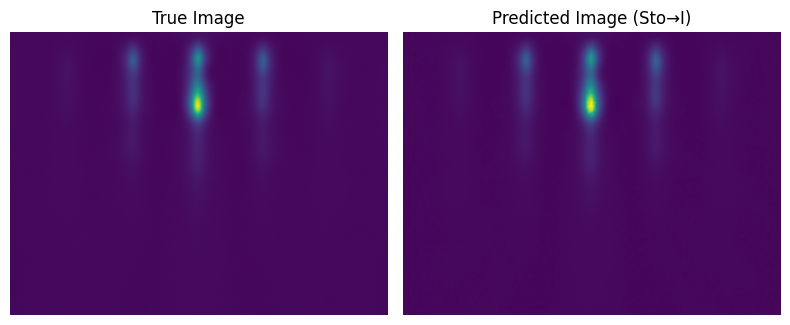

In [46]:
# ==================================
# CASE 2: Sto → (Image + Sto)
# ==================================

# use last sample
last_img = images[-1]          # ground-truth RHEED image (for reference)
last_sto = float(stoich[-1])   # input: stoichiometry

# ---- inference using STOICHIOMETRY as input ----
# Model predicts:
#   (1) RHEED image (sto → image)
#   (2) reconstructed stoichiometry (sto → sto)
img_pred, sto_pred = predict_from_input(
    model=model,
    input_data=last_sto,
    input_type="sto",
    IMG_HW=IMG_HW,
    min_stoich=min_stoich,
    max_stoich=max_stoich,
    min_image=min_image,
    max_image=max_image,
    device=device
)

print("Input: stoichiometry value → Output: RHEED image and reconstructed stoichiometry")
print()
print(
    f"[Sto → (Image + Sto)] "
    f"True sto (Input): {last_sto:.4f} | Recon sto: {sto_pred:.4f}"
)

# ---- visualize ----
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].imshow(last_img, cmap="viridis")
axes[0].set_title(f"True Image")
axes[0].axis("off")

axes[1].imshow(img_pred, cmap="viridis")
axes[1].set_title(f"Predicted Image (Sto→I)")
axes[1].axis("off")

plt.tight_layout()
plt.show()
